<a href="https://colab.research.google.com/github/lienn1911/my-mp3-file/blob/main/Online_Shopper_Intention.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# ============================================================
# STEP 1: IMPORT LIBRARIES
# ============================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import (accuracy_score, classification_report,
                            confusion_matrix, roc_auc_score, roc_curve,
                            mean_squared_error, r2_score, mean_absolute_error,
                            precision_score, recall_score, f1_score)
from sklearn.decomposition import PCA
from xgboost import XGBClassifier, XGBRegressor
import warnings
warnings.filterwarnings('ignore')

print("Libraries imported successfully!")

Libraries imported successfully!


In [2]:
# ============================================================
# STEP 2: LOAD DATASET
# ============================================================

print("\n" + "="*60)
print("STEP 2: DATA LOADING")
print("="*60 + "\n")

# Load Online Shoppers Intention dataset
data = pd.read_csv("online_shoppers_intention.csv")

print("Dataset loaded successfully!")
print(f"Shape: {data.shape}")
print("\nFirst 5 rows:")
print(data.head())

print("\nDataset Info:")
data.info()

print("\nColumn Names:")
print(data.columns.tolist())

print("\nSummary Statistics:")
print(data.describe())

print("\nMissing Values:")
print(data.isnull().sum())

# Check for duplicates
print(f"\nDuplicate Rows: {data.duplicated().sum()}")


STEP 2: DATA LOADING

Dataset loaded successfully!
Shape: (12330, 18)

First 5 rows:
   Administrative  Administrative_Duration  Informational  \
0               0                      0.0              0   
1               0                      0.0              0   
2               0                      0.0              0   
3               0                      0.0              0   
4               0                      0.0              0   

   Informational_Duration  ProductRelated  ProductRelated_Duration  \
0                     0.0               1                 0.000000   
1                     0.0               2                64.000000   
2                     0.0               1                 0.000000   
3                     0.0               2                 2.666667   
4                     0.0              10               627.500000   

   BounceRates  ExitRates  PageValues  SpecialDay Month  OperatingSystems  \
0         0.20       0.20         0.0         0.0

In [3]:
# ============================================================
# STEP 3: DATA EXPLORATION
# ============================================================

print("\n" + "="*60)
print("STEP 3: DATA EXPLORATION")
print("="*60 + "\n")

# Check target variable distribution
print("Target Variable: Revenue (Purchase)")
print(data['Revenue'].value_counts())
print("\nRevenue Distribution (%):")
print(data['Revenue'].value_counts(normalize=True) * 100)

# Explore key behavioral metrics
print("\n--- Session Duration Metrics ---")
behavioral_cols = ['Administrative_Duration', 'Informational_Duration', 'ProductRelated_Duration']
print(data[behavioral_cols].describe())

print("\n--- Page View Metrics ---")
page_cols = ['Administrative', 'Informational', 'ProductRelated']
print(data[page_cols].describe())

print("\n--- Bounce Rates & Exit Rates ---")
rate_cols = ['BounceRates', 'ExitRates', 'PageValues']
print(data[rate_cols].describe())

# Check categorical features
print("\n--- Categorical Features ---")
categorical_cols = ['Month', 'OperatingSystems', 'Browser', 'Region', 'TrafficType', 'VisitorType', 'Weekend']
for col in categorical_cols:
    if col in data.columns:
        print(f"\n{col}: {data[col].nunique()} unique values")
        print(data[col].value_counts().head())


STEP 3: DATA EXPLORATION

Target Variable: Revenue (Purchase)
Revenue
False    10422
True      1908
Name: count, dtype: int64

Revenue Distribution (%):
Revenue
False    84.525547
True     15.474453
Name: proportion, dtype: float64

--- Session Duration Metrics ---
       Administrative_Duration  Informational_Duration  \
count             12330.000000            12330.000000   
mean                 80.818611               34.472398   
std                 176.779107              140.749294   
min                   0.000000                0.000000   
25%                   0.000000                0.000000   
50%                   7.500000                0.000000   
75%                  93.256250                0.000000   
max                3398.750000             2549.375000   

       ProductRelated_Duration  
count             12330.000000  
mean               1194.746220  
std                1913.669288  
min                   0.000000  
25%                 184.137500  
50%         


STEP 4: DATA DISTRIBUTION ANALYSIS



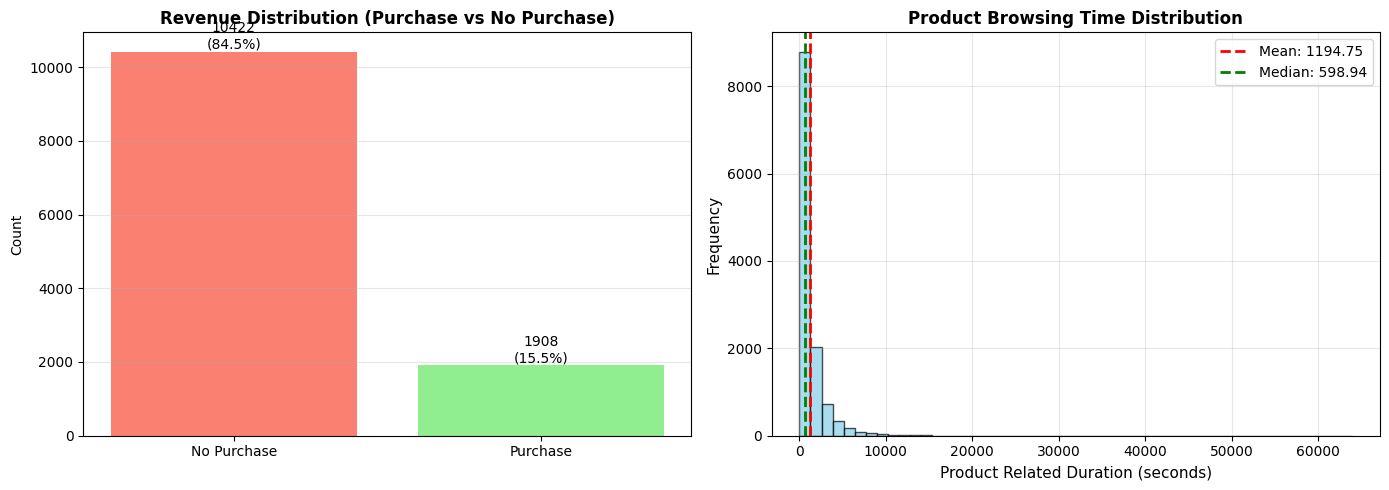


--- Outlier Detection (IQR Method) ---
Administrative_Duration: 1172 outliers (9.51%)
Informational_Duration: 2405 outliers (19.51%)
ProductRelated_Duration: 961 outliers (7.79%)
BounceRates: 1551 outliers (12.58%)
ExitRates: 1099 outliers (8.91%)
PageValues: 2730 outliers (22.14%)

--- Correlation with Revenue ---
Revenue_Numeric            1.000000
PageValues                 0.492569
ProductRelated             0.158538
ProductRelated_Duration    0.152373
Administrative             0.138917
Informational              0.095200
Administrative_Duration    0.093587
Informational_Duration     0.070345
Browser                    0.023984
TrafficType               -0.005113
Name: Revenue_Numeric, dtype: float64


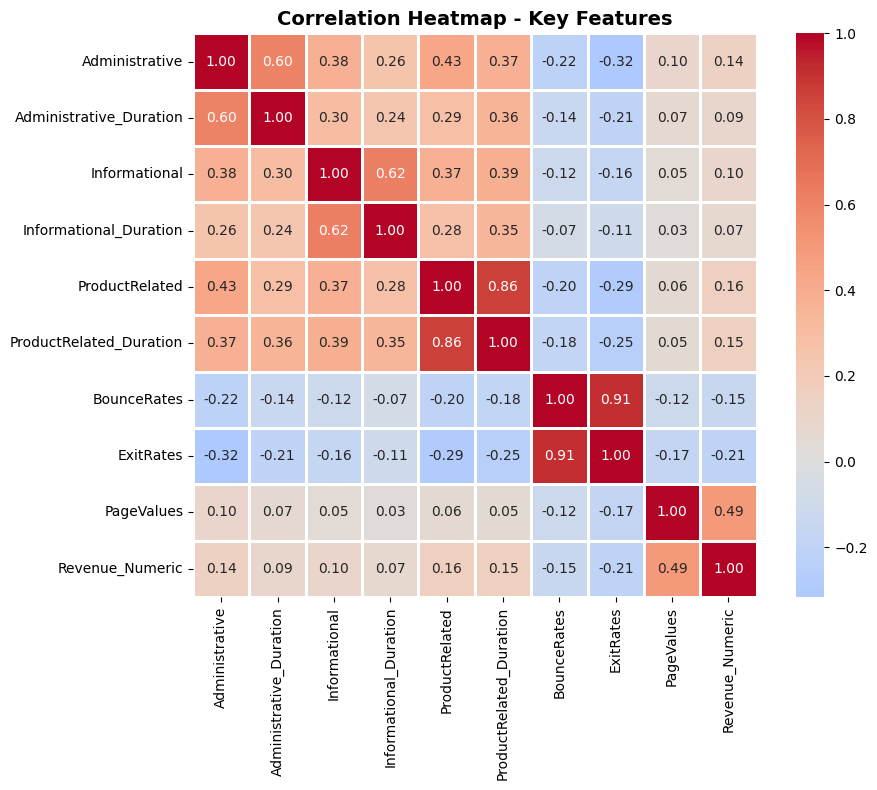

In [4]:
# ============================================================
# STEP 4: DATA DISTRIBUTION ANALYSIS
# ============================================================

print("\n" + "="*60)
print("STEP 4: DATA DISTRIBUTION ANALYSIS")
print("="*60 + "\n")

# Revenue distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Count plot
revenue_counts = data['Revenue'].value_counts()
axes[0].bar(['No Purchase', 'Purchase'], revenue_counts.values, color=['salmon', 'lightgreen'])
axes[0].set_title('Revenue Distribution (Purchase vs No Purchase)', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Count')
axes[0].grid(axis='y', alpha=0.3)
for i, v in enumerate(revenue_counts.values):
    axes[0].text(i, v, f'{v}\n({v/len(data)*100:.1f}%)', ha='center', va='bottom')

# Session duration distribution
axes[1].hist(data['ProductRelated_Duration'], bins=50, color='skyblue', edgecolor='black', alpha=0.7)
axes[1].axvline(data['ProductRelated_Duration'].mean(), color='red', linestyle='--',
                linewidth=2, label=f'Mean: {data["ProductRelated_Duration"].mean():.2f}')
axes[1].axvline(data['ProductRelated_Duration'].median(), color='green', linestyle='--',
                linewidth=2, label=f'Median: {data["ProductRelated_Duration"].median():.2f}')
axes[1].set_xlabel('Product Related Duration (seconds)', fontsize=11)
axes[1].set_ylabel('Frequency', fontsize=11)
axes[1].set_title('Product Browsing Time Distribution', fontsize=12, fontweight='bold')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Outlier detection for key metrics
print("\n--- Outlier Detection (IQR Method) ---")
numeric_cols = ['Administrative_Duration', 'Informational_Duration', 'ProductRelated_Duration',
                'BounceRates', 'ExitRates', 'PageValues']

for col in numeric_cols:
    Q1 = data[col].quantile(0.25)
    Q3 = data[col].quantile(0.75)
    IQR = Q3 - Q1
    outliers = ((data[col] < (Q1 - 1.5 * IQR)) | (data[col] > (Q3 + 1.5 * IQR))).sum()
    print(f"{col}: {outliers} outliers ({outliers/len(data)*100:.2f}%)")

# Correlation analysis
print("\n--- Correlation with Revenue ---")
# Convert Revenue to numeric
data['Revenue_Numeric'] = data['Revenue'].astype(int)
numeric_data = data.select_dtypes(include=[np.number])
correlation = numeric_data.corr()['Revenue_Numeric'].sort_values(ascending=False)
print(correlation.head(10))

# Correlation heatmap for key features
plt.figure(figsize=(10, 8))
key_features = ['Administrative', 'Administrative_Duration', 'Informational',
                'Informational_Duration', 'ProductRelated', 'ProductRelated_Duration',
                'BounceRates', 'ExitRates', 'PageValues', 'Revenue_Numeric']
corr_matrix = data[key_features].corr()
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0,
            square=True, linewidths=1)
plt.title('Correlation Heatmap - Key Features', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

In [5]:
# ============================================================
# STEP 5: FEATURE ENGINEERING
# ============================================================

print("\n" + "="*60)
print("STEP 5: FEATURE ENGINEERING")
print("="*60 + "\n")

# Create behavioral features
# Total session duration
data['Total_Duration'] = (data['Administrative_Duration'] +
                          data['Informational_Duration'] +
                          data['ProductRelated_Duration'])

# Total pages viewed
data['Total_Pages'] = (data['Administrative'] +
                       data['Informational'] +
                       data['ProductRelated'])

# Average time per page
data['Avg_Time_Per_Page'] = data['Total_Duration'] / (data['Total_Pages'] + 1)  # +1 to avoid division by zero

# Engagement score (normalized page value)
data['Engagement_Score'] = data['PageValues'] / (data['Total_Duration'] + 1)

# Bounce rate category
data['High_Bounce'] = (data['BounceRates'] > data['BounceRates'].median()).astype(int)

# Exit rate category
data['High_Exit'] = (data['ExitRates'] > data['ExitRates'].median()).astype(int)

# Shopping intensity (product pages ratio)
data['Product_Page_Ratio'] = data['ProductRelated'] / (data['Total_Pages'] + 1)

# Weekend shopper flag (already exists, ensure boolean)
data['Is_Weekend'] = data['Weekend'].astype(int)

# Visitor type encoding
data['Is_Returning_Visitor'] = (data['VisitorType'] == 'Returning_Visitor').astype(int)

# Month encoding (create season)
month_to_season = {
    'Feb': 'Winter', 'Mar': 'Spring', 'May': 'Spring', 'June': 'Summer',
    'Jul': 'Summer', 'Aug': 'Summer', 'Sep': 'Autumn', 'Oct': 'Autumn',
    'Nov': 'Autumn', 'Dec': 'Winter'
}
data['Season'] = data['Month'].map(month_to_season)

# Special days encoding
data['Is_Special_Day'] = (data['SpecialDay'] > 0).astype(int)

print("Feature Engineering Completed!")
print(f"\nNew features created:")
print("- Total_Duration: Total time spent on site")
print("- Total_Pages: Total pages viewed")
print("- Avg_Time_Per_Page: Average time per page")
print("- Engagement_Score: Normalized page value")
print("- High_Bounce: High bounce rate flag")
print("- High_Exit: High exit rate flag")
print("- Product_Page_Ratio: Proportion of product pages")
print("- Is_Weekend: Weekend shopping flag")
print("- Is_Returning_Visitor: Returning visitor flag")
print("- Season: Seasonal category")
print("- Is_Special_Day: Special day indicator")

print("\nSample of engineered features:")
engineered_features = ['Total_Duration', 'Total_Pages', 'Avg_Time_Per_Page',
                       'Engagement_Score', 'Product_Page_Ratio', 'Revenue']
print(data[engineered_features].head(10))


STEP 5: FEATURE ENGINEERING

Feature Engineering Completed!

New features created:
- Total_Duration: Total time spent on site
- Total_Pages: Total pages viewed
- Avg_Time_Per_Page: Average time per page
- Engagement_Score: Normalized page value
- High_Bounce: High bounce rate flag
- High_Exit: High exit rate flag
- Product_Page_Ratio: Proportion of product pages
- Is_Weekend: Weekend shopping flag
- Is_Returning_Visitor: Returning visitor flag
- Season: Seasonal category
- Is_Special_Day: Special day indicator

Sample of engineered features:
   Total_Duration  Total_Pages  Avg_Time_Per_Page  Engagement_Score  \
0        0.000000            1           0.000000               0.0   
1       64.000000            2          21.333333               0.0   
2        0.000000            1           0.000000               0.0   
3        2.666667            2           0.888889               0.0   
4      627.500000           10          57.045455               0.0   
5      154.216667        

In [6]:
# ============================================================
# STEP 6: DATA PREPROCESSING FOR MODELING
# ============================================================

print("\n" + "="*60)
print("STEP 6: DATA PREPROCESSING")
print("="*60 + "\n")

# Select features for modeling
# Behavioral features
features = [
    'Administrative', 'Administrative_Duration',
    'Informational', 'Informational_Duration',
    'ProductRelated', 'ProductRelated_Duration',
    'BounceRates', 'ExitRates', 'PageValues',
    'Total_Duration', 'Total_Pages', 'Avg_Time_Per_Page',
    'Engagement_Score', 'Product_Page_Ratio',
    'High_Bounce', 'High_Exit',
    'Is_Weekend', 'Is_Returning_Visitor', 'Is_Special_Day'
]

print(f"Selected {len(features)} features for modeling:")
for i, feat in enumerate(features, 1):
    print(f"{i}. {feat}")

# Prepare X and y
X = data[features]
y_classification = data['Revenue'].astype(int)  # Target: Purchase (1) or Not (0)
y_regression = data['PageValues']  # Target: Page value as proxy for transaction value

print(f"\nX shape: {X.shape}")
print(f"y_classification shape: {y_classification.shape}")
print(f"y_regression shape: {y_regression.shape}")

print(f"\nClass distribution:")
print(y_classification.value_counts())
print(f"\nClass balance: {y_classification.mean()*100:.2f}% purchased")


STEP 6: DATA PREPROCESSING

Selected 19 features for modeling:
1. Administrative
2. Administrative_Duration
3. Informational
4. Informational_Duration
5. ProductRelated
6. ProductRelated_Duration
7. BounceRates
8. ExitRates
9. PageValues
10. Total_Duration
11. Total_Pages
12. Avg_Time_Per_Page
13. Engagement_Score
14. Product_Page_Ratio
15. High_Bounce
16. High_Exit
17. Is_Weekend
18. Is_Returning_Visitor
19. Is_Special_Day

X shape: (12330, 19)
y_classification shape: (12330,)
y_regression shape: (12330,)

Class distribution:
Revenue
0    10422
1     1908
Name: count, dtype: int64

Class balance: 15.47% purchased


In [7]:

# ============================================================
# STEP 7: CLASSIFICATION TASK - PURCHASE PREDICTION
# ============================================================

print("\n" + "="*60)
print("STEP 7: CLASSIFICATION - PURCHASE PREDICTION")
print("="*60 + "\n")

# Train-test split with stratification
X_train_clf, X_test_clf, y_train_clf, y_test_clf = train_test_split(
    X, y_classification, test_size=0.2, random_state=42, stratify=y_classification
)

print(f"Training set: {X_train_clf.shape}")
print(f"Test set: {X_test_clf.shape}")
print(f"\nTrain class distribution:")
print(y_train_clf.value_counts())
print(f"\nTest class distribution:")
print(y_test_clf.value_counts())

# Feature scaling
scaler_clf = StandardScaler()
X_train_clf_scaled = scaler_clf.fit_transform(X_train_clf)
X_test_clf_scaled = scaler_clf.transform(X_test_clf)

print("\nFeature scaling completed (StandardScaler)")

# -------------------- Model 1: Random Forest Classifier --------------------
print("\n" + "-"*60)
print("MODEL 1: RANDOM FOREST CLASSIFIER")
print("-"*60)

rf_clf = RandomForestClassifier(
    n_estimators=200,
    max_depth=15,
    min_samples_split=5,
    random_state=42,
    n_jobs=-1
)

rf_clf.fit(X_train_clf_scaled, y_train_clf)
rf_clf_pred = rf_clf.predict(X_test_clf_scaled)
rf_clf_proba = rf_clf.predict_proba(X_test_clf_scaled)[:, 1]

rf_clf_acc = accuracy_score(y_test_clf, rf_clf_pred)
rf_precision = precision_score(y_test_clf, rf_clf_pred)
rf_recall = recall_score(y_test_clf, rf_clf_pred)
rf_f1 = f1_score(y_test_clf, rf_clf_pred)
rf_clf_auc = roc_auc_score(y_test_clf, rf_clf_proba)

print(f"\nAccuracy: {rf_clf_acc:.4f}")
print(f"Precision: {rf_precision:.4f}")
print(f"Recall: {rf_recall:.4f}")
print(f"F1-Score: {rf_f1:.4f}")
print(f"ROC-AUC Score: {rf_clf_auc:.4f}")
print("\nClassification Report:")
print(classification_report(y_test_clf, rf_clf_pred, target_names=['No Purchase', 'Purchase']))

# -------------------- Model 2: XGBoost Classifier --------------------
print("\n" + "-"*60)
print("MODEL 2: XGBOOST CLASSIFIER")
print("-"*60)

xgb_clf = XGBClassifier(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1,
    eval_metric='logloss'
)

xgb_clf.fit(X_train_clf_scaled, y_train_clf)
xgb_clf_pred = xgb_clf.predict(X_test_clf_scaled)
xgb_clf_proba = xgb_clf.predict_proba(X_test_clf_scaled)[:, 1]

xgb_clf_acc = accuracy_score(y_test_clf, xgb_clf_pred)
xgb_precision = precision_score(y_test_clf, xgb_clf_pred)
xgb_recall = recall_score(y_test_clf, xgb_clf_pred)
xgb_f1 = f1_score(y_test_clf, xgb_clf_pred)
xgb_clf_auc = roc_auc_score(y_test_clf, xgb_clf_proba)

print(f"\nAccuracy: {xgb_clf_acc:.4f}")
print(f"Precision: {xgb_precision:.4f}")
print(f"Recall: {xgb_recall:.4f}")
print(f"F1-Score: {xgb_f1:.4f}")
print(f"ROC-AUC Score: {xgb_clf_auc:.4f}")
print("\nClassification Report:")
print(classification_report(y_test_clf, xgb_clf_pred, target_names=['No Purchase', 'Purchase']))

# -------------------- Classification Model Comparison --------------------
print("\n" + "="*60)
print("CLASSIFICATION MODEL COMPARISON")
print("="*60 + "\n")

classification_results = pd.DataFrame({
    'Model': ['Random Forest', 'XGBoost'],
    'Accuracy': [rf_clf_acc, xgb_clf_acc],
    'Precision': [rf_precision, xgb_precision],
    'Recall': [rf_recall, xgb_recall],
    'F1-Score': [rf_f1, xgb_f1],
    'ROC-AUC': [rf_clf_auc, xgb_clf_auc]
})

print(classification_results)

best_clf_idx = classification_results['Accuracy'].idxmax()
best_clf_model = classification_results.loc[best_clf_idx, 'Model']
print(f"\n🏆 Best Classification Model: {best_clf_model}")


STEP 7: CLASSIFICATION - PURCHASE PREDICTION

Training set: (9864, 19)
Test set: (2466, 19)

Train class distribution:
Revenue
0    8338
1    1526
Name: count, dtype: int64

Test class distribution:
Revenue
0    2084
1     382
Name: count, dtype: int64

Feature scaling completed (StandardScaler)

------------------------------------------------------------
MODEL 1: RANDOM FOREST CLASSIFIER
------------------------------------------------------------

Accuracy: 0.8938
Precision: 0.6961
Recall: 0.5576
F1-Score: 0.6192
ROC-AUC Score: 0.8924

Classification Report:
              precision    recall  f1-score   support

 No Purchase       0.92      0.96      0.94      2084
    Purchase       0.70      0.56      0.62       382

    accuracy                           0.89      2466
   macro avg       0.81      0.76      0.78      2466
weighted avg       0.89      0.89      0.89      2466


------------------------------------------------------------
MODEL 2: XGBOOST CLASSIFIER
--------------


STEP 8: CLASSIFICATION VISUALIZATIONS



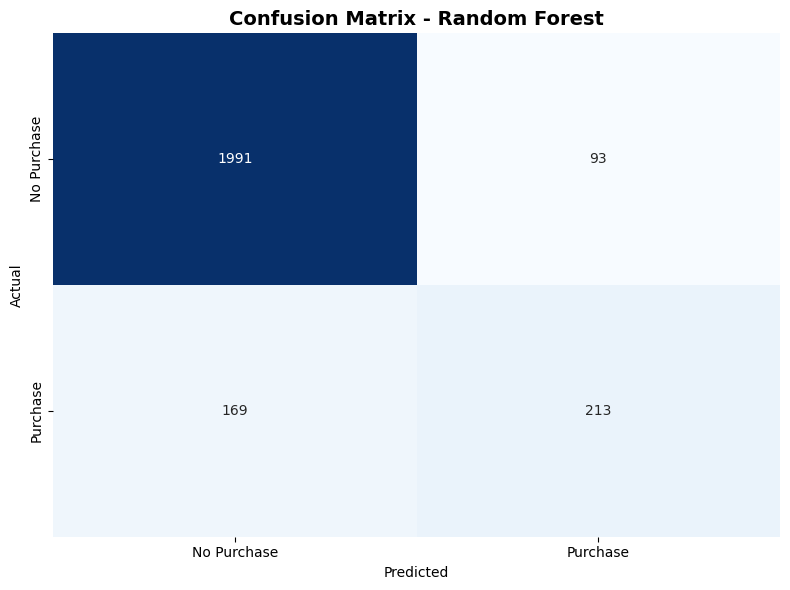

Confusion Matrix Interpretation:
True Negatives (Correctly predicted No Purchase): 1991
False Positives (Incorrectly predicted Purchase): 93
False Negatives (Missed Purchases): 169
True Positives (Correctly predicted Purchase): 213


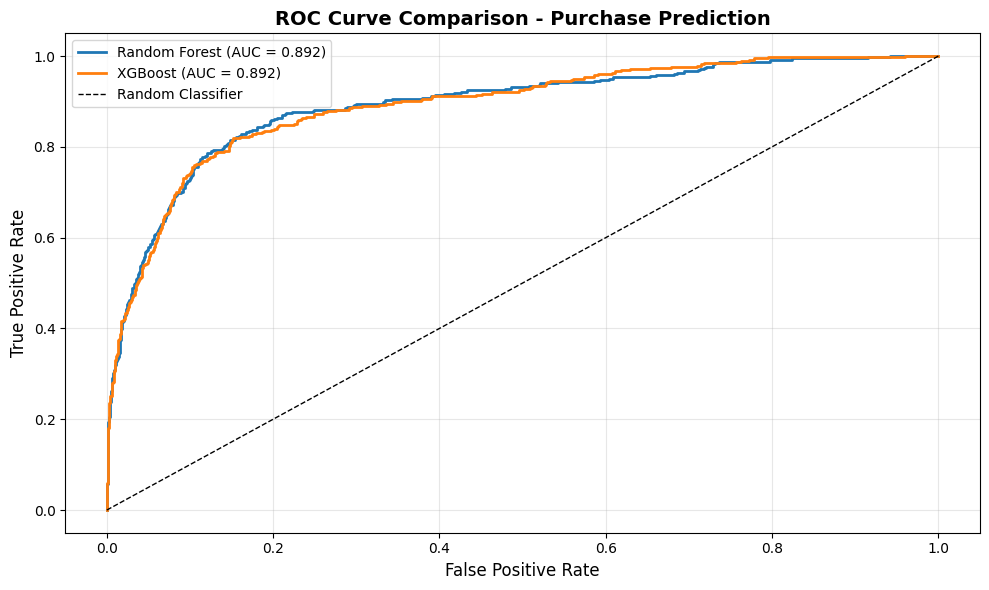

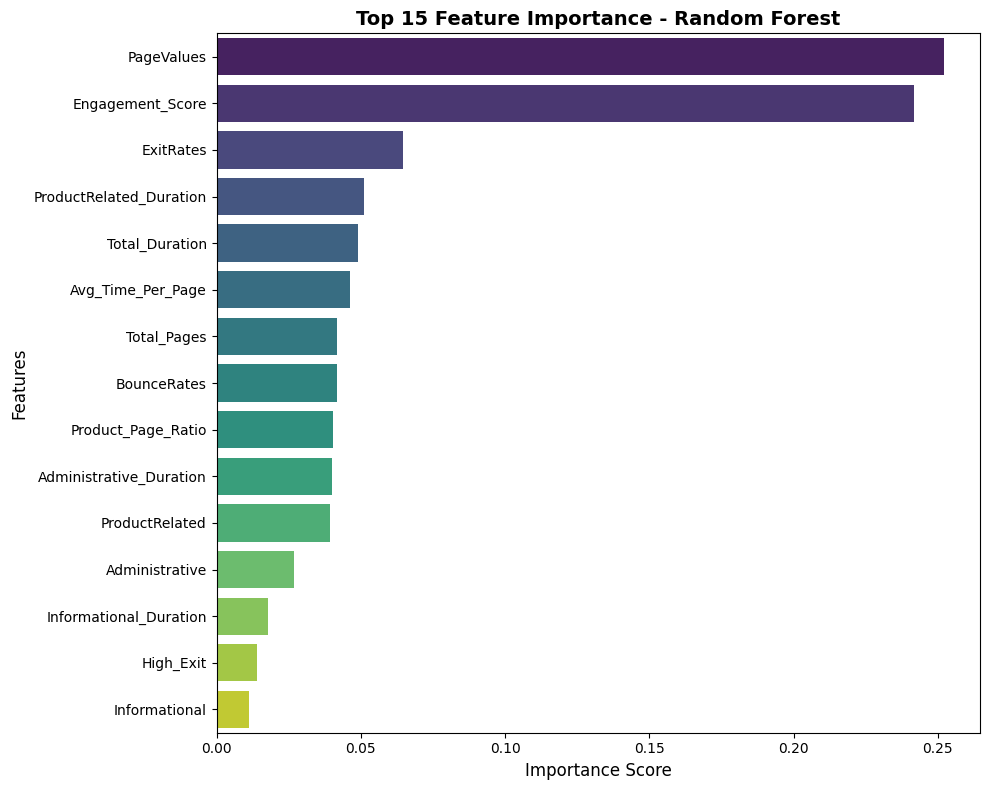


Top 10 Most Important Features:
                    Feature  Importance
8                PageValues    0.252041
12         Engagement_Score    0.241770
7                 ExitRates    0.064760
5   ProductRelated_Duration    0.051179
9            Total_Duration    0.048892
11        Avg_Time_Per_Page    0.046275
10              Total_Pages    0.041848
6               BounceRates    0.041701
13       Product_Page_Ratio    0.040342
1   Administrative_Duration    0.040074


In [8]:
# ============================================================
# STEP 8: CLASSIFICATION VISUALIZATIONS
# ============================================================

print("\n" + "="*60)
print("STEP 8: CLASSIFICATION VISUALIZATIONS")
print("="*60 + "\n")

# Select best model
best_clf = xgb_clf if best_clf_model == 'XGBoost' else rf_clf
best_clf_pred = xgb_clf_pred if best_clf_model == 'XGBoost' else rf_clf_pred

# Confusion Matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test_clf, best_clf_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['No Purchase', 'Purchase'],
            yticklabels=['No Purchase', 'Purchase'])
plt.title(f'Confusion Matrix - {best_clf_model}', fontsize=14, fontweight='bold')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.tight_layout()
plt.show()

print("Confusion Matrix Interpretation:")
print(f"True Negatives (Correctly predicted No Purchase): {cm[0,0]}")
print(f"False Positives (Incorrectly predicted Purchase): {cm[0,1]}")
print(f"False Negatives (Missed Purchases): {cm[1,0]}")
print(f"True Positives (Correctly predicted Purchase): {cm[1,1]}")

# ROC Curve Comparison
plt.figure(figsize=(10, 6))
fpr_rf, tpr_rf, _ = roc_curve(y_test_clf, rf_clf_proba)
fpr_xgb, tpr_xgb, _ = roc_curve(y_test_clf, xgb_clf_proba)

plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {rf_clf_auc:.3f})', linewidth=2)
plt.plot(fpr_xgb, tpr_xgb, label=f'XGBoost (AUC = {xgb_clf_auc:.3f})', linewidth=2)
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier', linewidth=1)

plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curve Comparison - Purchase Prediction', fontsize=14, fontweight='bold')
plt.legend(fontsize=10)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Feature Importance
plt.figure(figsize=(10, 8))
importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': best_clf.feature_importances_
}).sort_values(by='Importance', ascending=False)

sns.barplot(data=importance_df.head(15), x='Importance', y='Feature',
            hue='Feature', dodge=False, palette='viridis', legend=False)
plt.title(f'Top 15 Feature Importance - {best_clf_model}', fontsize=14, fontweight='bold')
plt.xlabel('Importance Score', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.tight_layout()
plt.show()

print("\nTop 10 Most Important Features:")
print(importance_df.head(10))

In [9]:
# ============================================================
# STEP 9: REGRESSION TASK - PAGE VALUE PREDICTION
# ============================================================

print("\n" + "="*60)
print("STEP 9: REGRESSION - PAGE VALUE PREDICTION")
print("="*60 + "\n")

# Train-test split for regression
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(
    X, y_regression, test_size=0.2, random_state=42
)

print(f"Training set: {X_train_reg.shape}")
print(f"Test set: {X_test_reg.shape}")

# Feature scaling
scaler_reg = StandardScaler()
X_train_reg_scaled = scaler_reg.fit_transform(X_train_reg)
X_test_reg_scaled = scaler_reg.transform(X_test_reg)

# Define MAPE function
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    mask = y_true != 0
    if mask.sum() == 0:
        return 0
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

# -------------------- Model 1: Linear Regression --------------------
print("\n" + "-"*60)
print("MODEL 1: LINEAR REGRESSION (Baseline)")
print("-"*60)

lr = LinearRegression()
lr.fit(X_train_reg_scaled, y_train_reg)
lr_pred = lr.predict(X_test_reg_scaled)

lr_mse = mean_squared_error(y_test_reg, lr_pred)
lr_rmse = np.sqrt(lr_mse)
lr_mae = mean_absolute_error(y_test_reg, lr_pred)
lr_r2 = r2_score(y_test_reg, lr_pred)
lr_mape = mean_absolute_percentage_error(y_test_reg, lr_pred)

print(f"MSE: {lr_mse:.2f}")
print(f"RMSE: {lr_rmse:.2f}")
print(f"MAE: {lr_mae:.2f}")
print(f"MAPE: {lr_mape:.2f}%")
print(f"R² Score: {lr_r2:.4f}")

# -------------------- Model 2: Random Forest Regressor --------------------
print("\n" + "-"*60)
print("MODEL 2: RANDOM FOREST REGRESSOR")
print("-"*60)

rf_reg = RandomForestRegressor(
    n_estimators=200,
    max_depth=20,
    min_samples_split=5,
    random_state=42,
    n_jobs=-1
)

rf_reg.fit(X_train_reg_scaled, y_train_reg)
rf_pred = rf_reg.predict(X_test_reg_scaled)

rf_mse = mean_squared_error(y_test_reg, rf_pred)
rf_rmse = np.sqrt(rf_mse)
rf_mae = mean_absolute_error(y_test_reg, rf_pred)
rf_r2 = r2_score(y_test_reg, rf_pred)
rf_mape = mean_absolute_percentage_error(y_test_reg, rf_pred)

print(f"MSE: {rf_mse:.2f}")
print(f"RMSE: {rf_rmse:.2f}")
print(f"MAE: {rf_mae:.2f}")
print(f"MAPE: {rf_mape:.2f}%")
print(f"R² Score: {rf_r2:.4f}")

# -------------------- Model 3: XGBoost Regressor --------------------
print("\n" + "-"*60)
print("MODEL 3: XGBOOST REGRESSOR")
print("-"*60)

xgb_reg = XGBRegressor(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)

xgb_reg.fit(X_train_reg_scaled, y_train_reg)
xgb_pred = xgb_reg.predict(X_test_reg_scaled)

xgb_mse = mean_squared_error(y_test_reg, xgb_pred)
xgb_rmse = np.sqrt(xgb_mse)
xgb_mae = mean_absolute_error(y_test_reg, xgb_pred)
xgb_r2 = r2_score(y_test_reg, xgb_pred)
xgb_mape = mean_absolute_percentage_error(y_test_reg, xgb_pred)

print(f"MSE: {xgb_mse:.2f}")
print(f"RMSE: {xgb_rmse:.2f}")
print(f"MAE: {xgb_mae:.2f}")
print(f"MAPE: {xgb_mape:.2f}%")
print(f"R² Score: {xgb_r2:.4f}")

# -------------------- Regression Model Comparison --------------------
print("\n" + "="*60)
print("REGRESSION MODEL COMPARISON")
print("="*60 + "\n")

regression_results = pd.DataFrame({
    'Model': ['Linear Regression', 'Random Forest', 'XGBoost'],
    'MSE': [lr_mse, rf_mse, xgb_mse],
    'RMSE': [lr_rmse, rf_rmse, xgb_rmse],
    'MAE': [lr_mae, rf_mae, xgb_mae],
    'MAPE (%)': [lr_mape, rf_mape, xgb_mape],
    'R² Score': [lr_r2, rf_r2, xgb_r2]
})

print(regression_results)

best_reg_idx = regression_results['R² Score'].idxmax()
best_reg_model = regression_results.loc[best_reg_idx, 'Model']
print(f"\n🏆 Best Regression Model: {best_reg_model}")


STEP 9: REGRESSION - PAGE VALUE PREDICTION

Training set: (9864, 19)
Test set: (2466, 19)

------------------------------------------------------------
MODEL 1: LINEAR REGRESSION (Baseline)
------------------------------------------------------------
MSE: 0.00
RMSE: 0.00
MAE: 0.00
MAPE: 0.00%
R² Score: 1.0000

------------------------------------------------------------
MODEL 2: RANDOM FOREST REGRESSOR
------------------------------------------------------------
MSE: 0.13
RMSE: 0.36
MAE: 0.03
MAPE: 0.35%
R² Score: 0.9996

------------------------------------------------------------
MODEL 3: XGBOOST REGRESSOR
------------------------------------------------------------
MSE: 4.00
RMSE: 2.00
MAE: 0.19
MAPE: 2.63%
R² Score: 0.9888

REGRESSION MODEL COMPARISON

               Model           MSE          RMSE           MAE      MAPE (%)  \
0  Linear Regression  5.362578e-27  7.322962e-14  5.008141e-14  1.810891e-12   
1      Random Forest  1.273480e-01  3.568585e-01  2.620696e-02  3.535254


STEP 10: REGRESSION VISUALIZATIONS & OPTIMIZATION



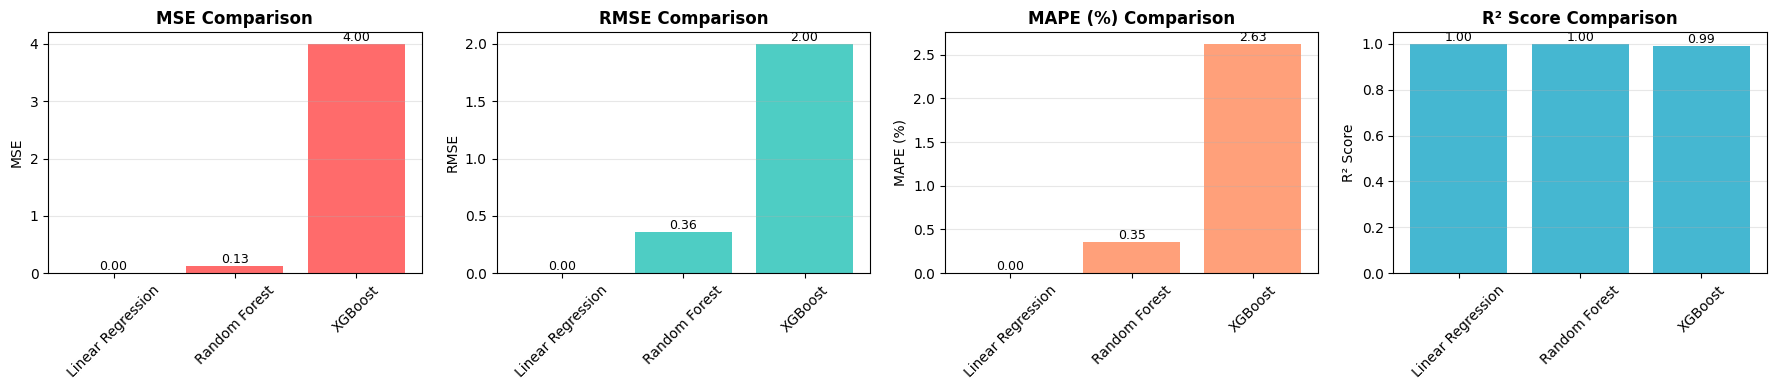

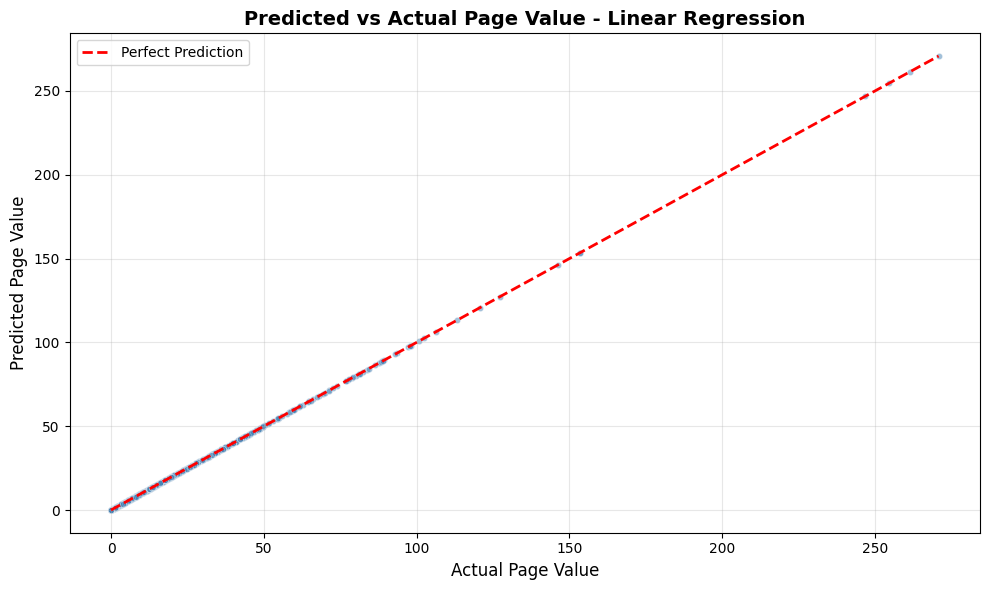

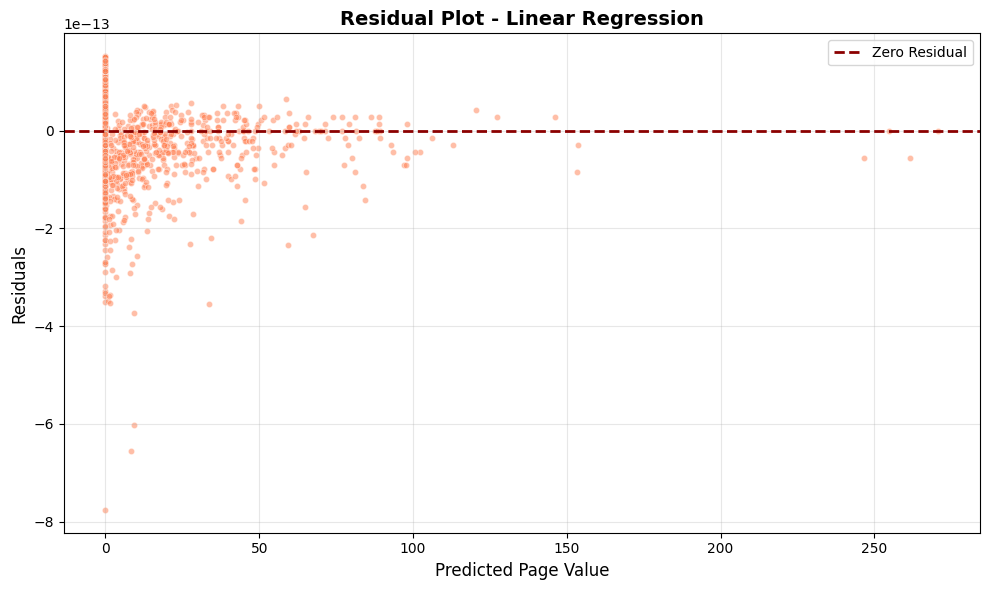

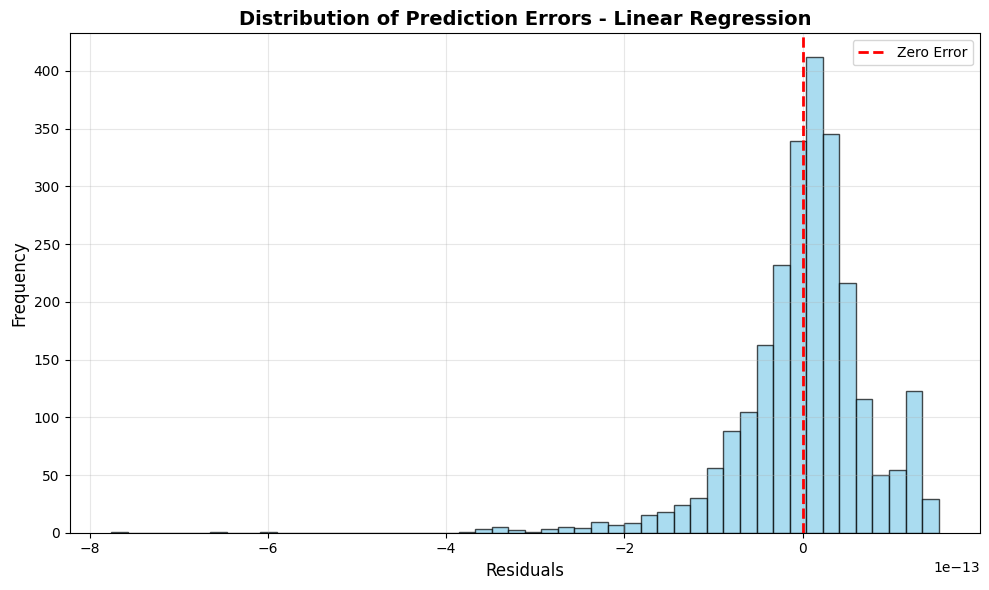

In [10]:
# ============================================================
# STEP 10: REGRESSION VISUALIZATIONS & OPTIMIZATION
# ============================================================

print("\n" + "="*60)
print("STEP 10: REGRESSION VISUALIZATIONS & OPTIMIZATION")
print("="*60 + "\n")

# Model Performance Comparison Visualization
fig, axes = plt.subplots(1, 4, figsize=(18, 4))

metrics = ['MSE', 'RMSE', 'MAPE (%)', 'R² Score']
colors = ['#FF6B6B', '#4ECDC4', '#FFA07A', '#45B7D1']

for idx, metric in enumerate(metrics):
    axes[idx].bar(regression_results['Model'], regression_results[metric],
                  color=colors[idx])
    axes[idx].set_title(f'{metric} Comparison', fontsize=12, fontweight='bold')
    axes[idx].set_ylabel(metric, fontsize=10)
    axes[idx].tick_params(axis='x', rotation=45)
    axes[idx].grid(axis='y', alpha=0.3)

    # Add value labels on bars
    for i, v in enumerate(regression_results[metric]):
        axes[idx].text(i, v, f'{v:.2f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

# Select best model for visualization
best_predictions = xgb_pred if best_reg_model == 'XGBoost' else (rf_pred if best_reg_model == 'Random Forest' else lr_pred)

# Predicted vs Actual Plot
plt.figure(figsize=(10, 6))
plt.scatter(y_test_reg, best_predictions, alpha=0.5, s=20, color='steelblue', edgecolors='white', linewidth=0.5)
plt.plot([y_test_reg.min(), y_test_reg.max()],
         [y_test_reg.min(), y_test_reg.max()],
         'r--', linewidth=2, label='Perfect Prediction')
plt.xlabel('Actual Page Value', fontsize=12)
plt.ylabel('Predicted Page Value', fontsize=12)
plt.title(f'Predicted vs Actual Page Value - {best_reg_model}', fontsize=14, fontweight='bold')
plt.legend(fontsize=10)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Residual Plot
residuals = y_test_reg - best_predictions

plt.figure(figsize=(10, 6))
plt.scatter(best_predictions, residuals, alpha=0.5, s=20, color='coral', edgecolors='white', linewidth=0.5)
plt.axhline(y=0, color='darkred', linestyle='--', linewidth=2, label='Zero Residual')
plt.xlabel('Predicted Page Value', fontsize=12)
plt.ylabel('Residuals', fontsize=12)
plt.title(f'Residual Plot - {best_reg_model}', fontsize=14, fontweight='bold')
plt.legend(fontsize=10)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Error Distribution
plt.figure(figsize=(10, 6))
plt.hist(residuals, bins=50, color='skyblue', edgecolor='black', alpha=0.7)
plt.xlabel('Residuals', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title(f'Distribution of Prediction Errors - {best_reg_model}', fontsize=14, fontweight='bold')
plt.axvline(x=0, color='red', linestyle='--', linewidth=2, label='Zero Error')
plt.legend(fontsize=10)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [11]:
# ============================================================
# HYPERPARAMETER TUNING - GRIDSEARCHCV
# ============================================================

print("\n" + "="*60)
print("HYPERPARAMETER TUNING - GRIDSEARCHCV")
print("="*60 + "\n")

# Hyperparameter tuning for XGBoost Classifier (best classification model)
print("--- Tuning XGBoost Classifier for Purchase Prediction ---\n")

param_grid_clf = {
    'n_estimators': [100, 200],
    'max_depth': [4, 6, 8],
    'learning_rate': [0.05, 0.1],
    'subsample': [0.8, 0.9],
    'colsample_bytree': [0.8, 0.9]
}

print("Parameter Grid:")
for key, value in param_grid_clf.items():
    print(f"  {key}: {value}")

print("\nPerforming GridSearchCV with 5-Fold Cross-Validation...")
print("This may take a few minutes...\n")

grid_clf = GridSearchCV(
    estimator=XGBClassifier(random_state=42, n_jobs=-1, eval_metric='logloss'),
    param_grid=param_grid_clf,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=0
)

grid_clf.fit(X_train_clf_scaled, y_train_clf)

print("GridSearchCV Completed!")
print(f"\nBest Parameters: {grid_clf.best_params_}")
print(f"Best Cross-Validation ROC-AUC Score: {grid_clf.best_score_:.4f}")

# Evaluate tuned model on test set
tuned_clf_pred = grid_clf.best_estimator_.predict(X_test_clf_scaled)
tuned_clf_proba = grid_clf.best_estimator_.predict_proba(X_test_clf_scaled)[:, 1]

tuned_clf_acc = accuracy_score(y_test_clf, tuned_clf_pred)
tuned_clf_auc = roc_auc_score(y_test_clf, tuned_clf_proba)
tuned_clf_precision = precision_score(y_test_clf, tuned_clf_pred)
tuned_clf_recall = recall_score(y_test_clf, tuned_clf_pred)
tuned_clf_f1 = f1_score(y_test_clf, tuned_clf_pred)

print(f"\nTuned Model Test Performance:")
print(f"  Accuracy: {tuned_clf_acc:.4f}")
print(f"  Precision: {tuned_clf_precision:.4f}")
print(f"  Recall: {tuned_clf_recall:.4f}")
print(f"  F1-Score: {tuned_clf_f1:.4f}")
print(f"  ROC-AUC: {tuned_clf_auc:.4f}")

print(f"\nImprovement Analysis:")
print(f"  Accuracy improvement: {tuned_clf_acc - xgb_clf_acc:+.4f}")
print(f"  ROC-AUC improvement: {tuned_clf_auc - xgb_clf_auc:+.4f}")



HYPERPARAMETER TUNING - GRIDSEARCHCV

--- Tuning XGBoost Classifier for Purchase Prediction ---

Parameter Grid:
  n_estimators: [100, 200]
  max_depth: [4, 6, 8]
  learning_rate: [0.05, 0.1]
  subsample: [0.8, 0.9]
  colsample_bytree: [0.8, 0.9]

Performing GridSearchCV with 5-Fold Cross-Validation...
This may take a few minutes...

GridSearchCV Completed!

Best Parameters: {'colsample_bytree': 0.9, 'learning_rate': 0.05, 'max_depth': 4, 'n_estimators': 100, 'subsample': 0.8}
Best Cross-Validation ROC-AUC Score: 0.9168

Tuned Model Test Performance:
  Accuracy: 0.8942
  Precision: 0.7079
  Recall: 0.5393
  F1-Score: 0.6122
  ROC-AUC: 0.9025

Improvement Analysis:
  Accuracy improvement: +0.0061
  ROC-AUC improvement: +0.0109



PCA VISUALIZATION



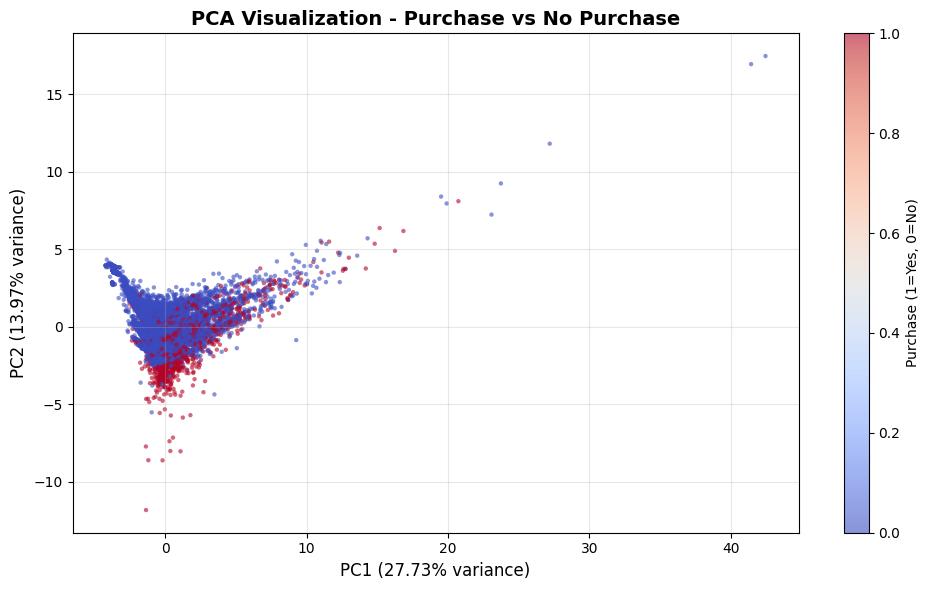

Explained variance by PC1: 0.2773 (27.73%)
Explained variance by PC2: 0.1397 (13.97%)
Total explained variance: 0.4170 (41.70%)


In [12]:
# ============================================================
# PCA VISUALIZATION
# ============================================================

print("\n" + "="*60)
print("PCA VISUALIZATION")
print("="*60 + "\n")

pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_clf_scaled)

plt.figure(figsize=(10, 6))
scatter = plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1],
                     c=y_train_clf, cmap='coolwarm',
                     alpha=0.6, s=10, edgecolors='none')
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)', fontsize=12)
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)', fontsize=12)
plt.title('PCA Visualization - Purchase vs No Purchase', fontsize=14, fontweight='bold')
plt.colorbar(scatter, label='Purchase (1=Yes, 0=No)')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Explained variance by PC1: {pca.explained_variance_ratio_[0]:.4f} ({pca.explained_variance_ratio_[0]*100:.2f}%)")
print(f"Explained variance by PC2: {pca.explained_variance_ratio_[1]:.4f} ({pca.explained_variance_ratio_[1]*100:.2f}%)")
print(f"Total explained variance: {sum(pca.explained_variance_ratio_):.4f} ({sum(pca.explained_variance_ratio_)*100:.2f}%)")


BUSINESS INSIGHTS - BEHAVIORAL ANALYSIS



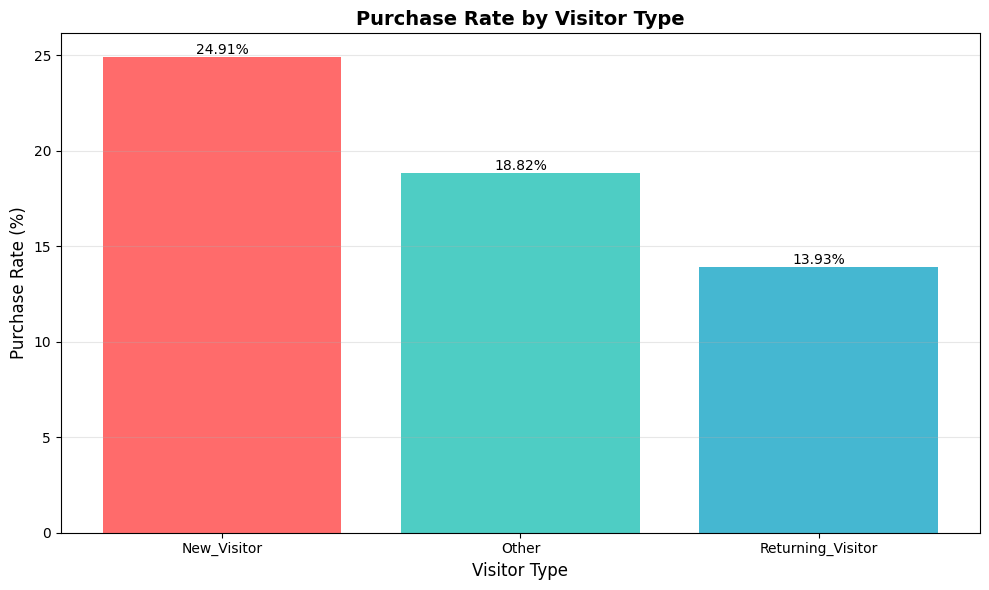

Purchase Rate by Visitor Type:
         VisitorType  Purchase_Rate  count
0        New_Visitor      24.911452   1694
1              Other      18.823529     85
2  Returning_Visitor      13.932329  10551


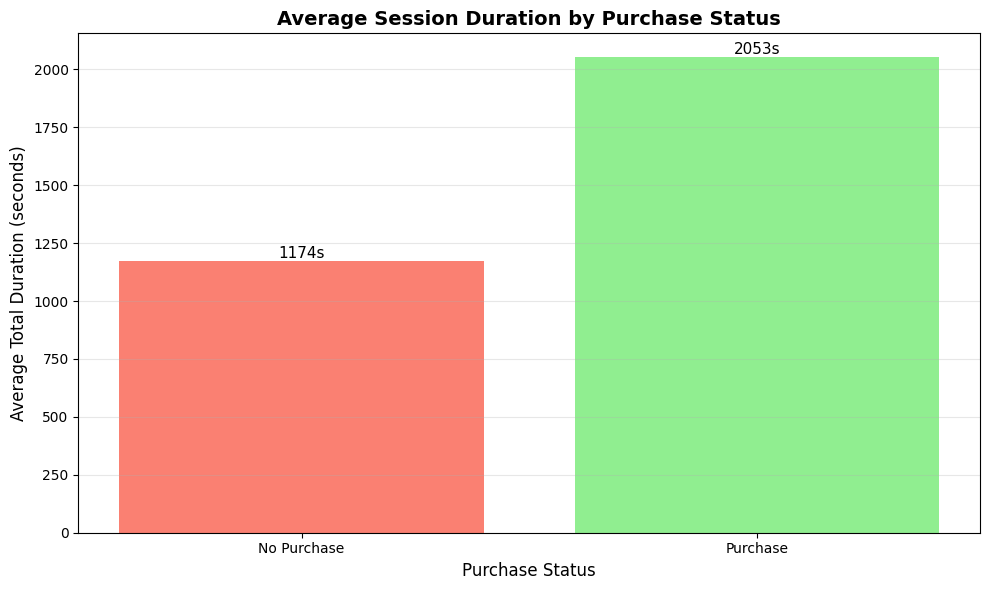


Average Session Duration Analysis:
  No Purchase: 1173.96 seconds
  Purchase: 2053.30 seconds
  Difference: 879.34 seconds (74.9% longer)


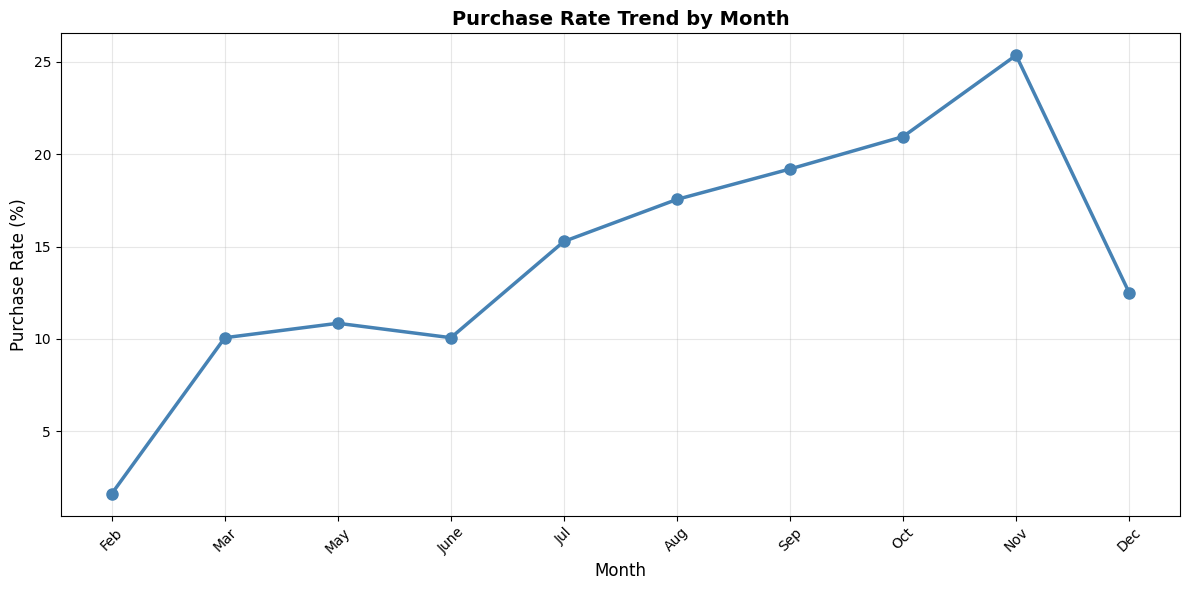


Monthly Purchase Rate:
  Month  Purchase_Rate  count
2   Feb       1.630435    184
5   Mar      10.068170   1907
6   May      10.850178   3364
4  June      10.069444    288
3   Jul      15.277778    432
0   Aug      17.551963    433
9   Sep      19.196429    448
8   Oct      20.947177    549
7   Nov      25.350233   2998
1   Dec      12.507238   1727


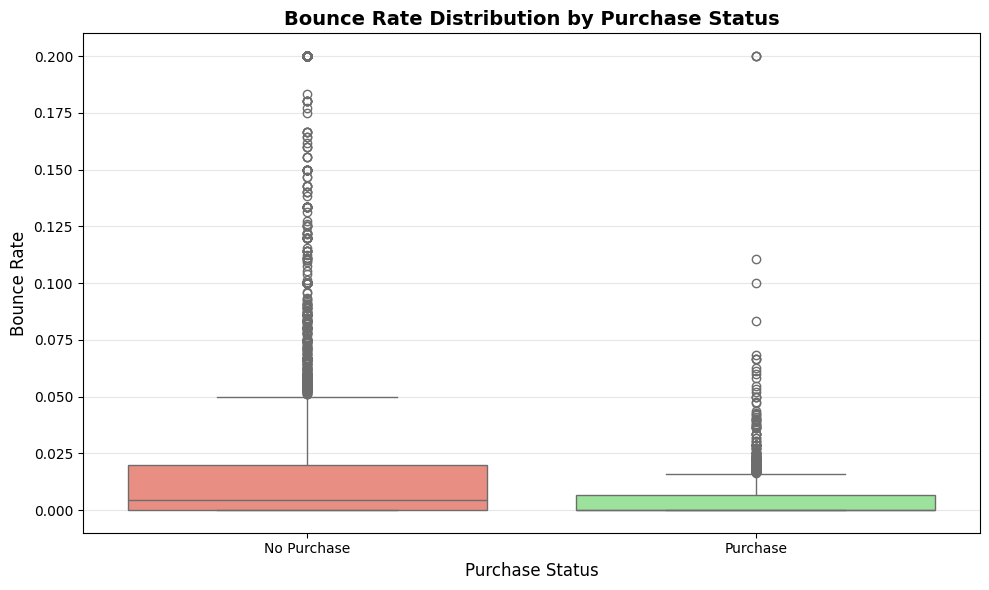


Bounce Rate Statistics by Purchase:
             mean       50%       std
Revenue                              
False    0.025317  0.004255  0.051877
True     0.005117  0.000000  0.012185

  No Purchase - Mean: 0.0253, Median: 0.0043
  Purchase - Mean: 0.0051, Median: 0.0000


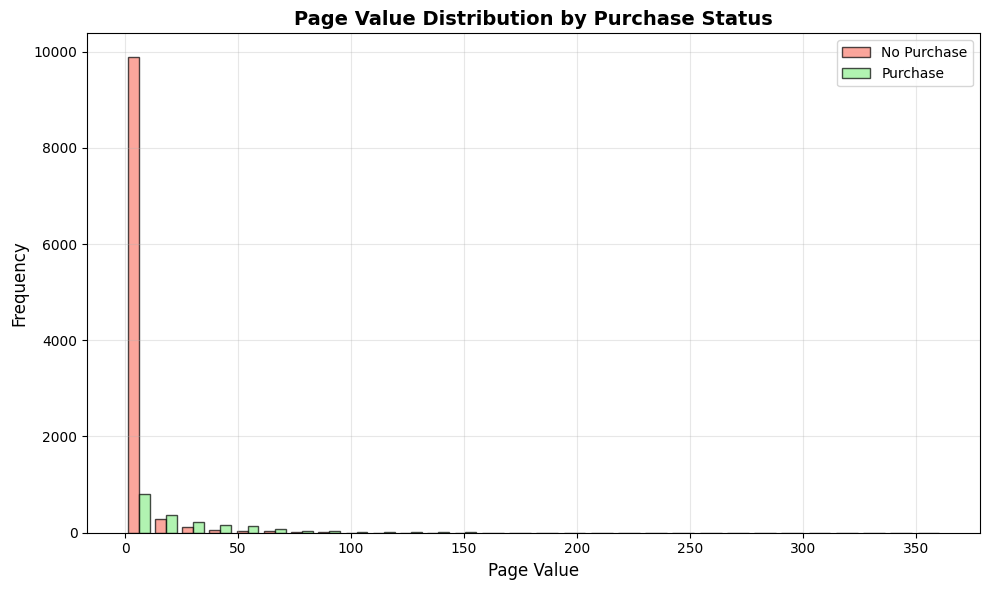


Page Value Statistics:
  No Purchase - Mean: 1.98, Median: 0.00
  Purchase - Mean: 27.26, Median: 16.76


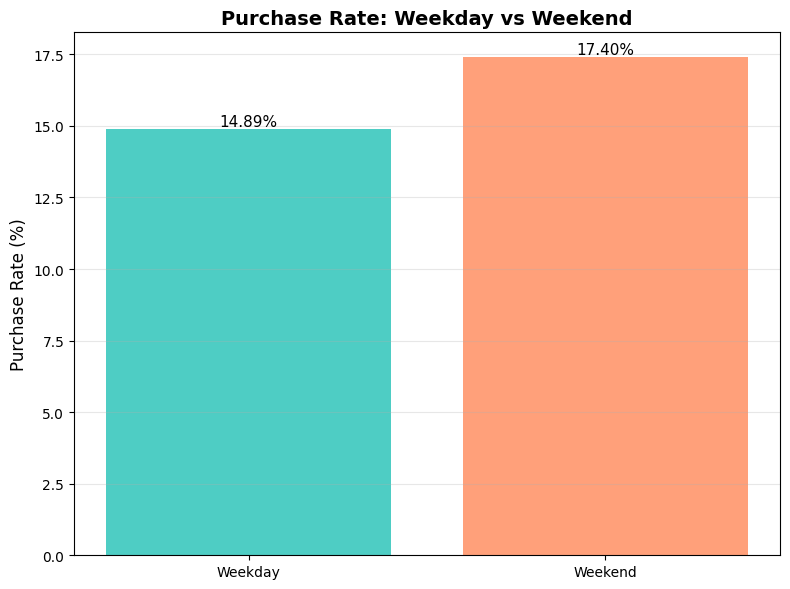


Weekend vs Weekday Purchase Rate:
  Weekday: 14.89%
  Weekend: 17.40%


In [14]:
# ============================================================
# BUSINESS INSIGHTS VISUALIZATIONS
# ============================================================

print("\n" + "="*60)
print("BUSINESS INSIGHTS - BEHAVIORAL ANALYSIS")
print("="*60 + "\n")

# 1. Purchase Rate by Visitor Type
plt.figure(figsize=(10, 6))
visitor_purchase = data.groupby('VisitorType')['Revenue'].agg(['sum', 'count', 'mean']).reset_index()
visitor_purchase['Purchase_Rate'] = visitor_purchase['mean'] * 100

bars = plt.bar(visitor_purchase['VisitorType'], visitor_purchase['Purchase_Rate'],
               color=['#FF6B6B', '#4ECDC4', '#45B7D1'])
plt.title('Purchase Rate by Visitor Type', fontsize=14, fontweight='bold')
plt.xlabel('Visitor Type', fontsize=12)
plt.ylabel('Purchase Rate (%)', fontsize=12)
plt.grid(axis='y', alpha=0.3)

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.2f}%', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

print("Purchase Rate by Visitor Type:")
print(visitor_purchase[['VisitorType', 'Purchase_Rate', 'count']])

# 2. Average Session Duration by Purchase Status
plt.figure(figsize=(10, 6))
duration_by_purchase = data.groupby('Revenue')['Total_Duration'].mean()

bars = plt.bar(['No Purchase', 'Purchase'], duration_by_purchase.values,
               color=['salmon', 'lightgreen'])
plt.title('Average Session Duration by Purchase Status', fontsize=14, fontweight='bold')
plt.xlabel('Purchase Status', fontsize=12)
plt.ylabel('Average Total Duration (seconds)', fontsize=12)
plt.grid(axis='y', alpha=0.3)

for i, (bar, val) in enumerate(zip(bars, duration_by_purchase.values)):
    plt.text(bar.get_x() + bar.get_width()/2., val,
             f'{val:.0f}s', ha='center', va='bottom', fontsize=11)

plt.tight_layout()
plt.show()

print("\nAverage Session Duration Analysis:")
print(f"  No Purchase: {duration_by_purchase[0]:.2f} seconds")
print(f"  Purchase: {duration_by_purchase[1]:.2f} seconds")
print(f"  Difference: {duration_by_purchase[1] - duration_by_purchase[0]:.2f} seconds ({(duration_by_purchase[1]/duration_by_purchase[0]-1)*100:.1f}% longer)")

# 3. Purchase Rate by Month
plt.figure(figsize=(12, 6))
month_purchase = data.groupby('Month')['Revenue'].agg(['sum', 'count', 'mean']).reset_index()
month_purchase['Purchase_Rate'] = month_purchase['mean'] * 100

# Sort by month order
month_order = ['Feb', 'Mar', 'May', 'June', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
# Only keep months that exist in the data
existing_months = [m for m in month_order if m in month_purchase['Month'].values]
month_purchase['Month'] = pd.Categorical(month_purchase['Month'], categories=existing_months, ordered=True)
month_purchase = month_purchase.sort_values('Month')

plt.plot(month_purchase['Month'], month_purchase['Purchase_Rate'],
         marker='o', linewidth=2.5, markersize=8, color='steelblue')
plt.title('Purchase Rate Trend by Month', fontsize=14, fontweight='bold')
plt.xlabel('Month', fontsize=12)
plt.ylabel('Purchase Rate (%)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print("\nMonthly Purchase Rate:")
print(month_purchase[['Month', 'Purchase_Rate', 'count']])

# 4. Bounce Rate vs Purchase
plt.figure(figsize=(10, 6))
sns.boxplot(data=data, x='Revenue', y='BounceRates', palette=['salmon', 'lightgreen'])
plt.title('Bounce Rate Distribution by Purchase Status', fontsize=14, fontweight='bold')
plt.xlabel('Purchase Status', fontsize=12)
plt.ylabel('Bounce Rate', fontsize=12)
plt.xticks([0, 1], ['No Purchase', 'Purchase'])
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

bounce_by_revenue = data.groupby('Revenue')['BounceRates'].describe()
print("\nBounce Rate Statistics by Purchase:")
print(bounce_by_revenue[['mean', '50%', 'std']])
print(f"\n  No Purchase - Mean: {bounce_by_revenue.loc[False, 'mean']:.4f}, Median: {bounce_by_revenue.loc[False, '50%']:.4f}")
print(f"  Purchase - Mean: {bounce_by_revenue.loc[True, 'mean']:.4f}, Median: {bounce_by_revenue.loc[True, '50%']:.4f}")

# 5. Page Value Distribution
plt.figure(figsize=(10, 6))
purchase_data = data[data['Revenue'] == True]['PageValues']
no_purchase_data = data[data['Revenue'] == False]['PageValues']

plt.hist([no_purchase_data, purchase_data], bins=30, label=['No Purchase', 'Purchase'],
         color=['salmon', 'lightgreen'], alpha=0.7, edgecolor='black')
plt.title('Page Value Distribution by Purchase Status', fontsize=14, fontweight='bold')
plt.xlabel('Page Value', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.legend(fontsize=10)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print("\nPage Value Statistics:")
print(f"  No Purchase - Mean: {no_purchase_data.mean():.2f}, Median: {no_purchase_data.median():.2f}")
print(f"  Purchase - Mean: {purchase_data.mean():.2f}, Median: {purchase_data.median():.2f}")

# 6. Weekend vs Weekday Purchase Rate
plt.figure(figsize=(8, 6))
weekend_purchase = data.groupby('Weekend')['Revenue'].mean() * 100

bars = plt.bar(['Weekday', 'Weekend'], weekend_purchase.values,
               color=['#4ECDC4', '#FFA07A'])
plt.title('Purchase Rate: Weekday vs Weekend', fontsize=14, fontweight='bold')
plt.ylabel('Purchase Rate (%)', fontsize=12)
plt.grid(axis='y', alpha=0.3)

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.2f}%', ha='center', va='bottom', fontsize=11)

plt.tight_layout()
plt.show()

print("\nWeekend vs Weekday Purchase Rate:")
print(f"  Weekday: {weekend_purchase[False]:.2f}%")
print(f"  Weekend: {weekend_purchase[True]:.2f}%")

In [19]:
# ============================================================
# FINAL SUMMARY
# ============================================================

print("\n" + "="*60)
print("FINAL SUMMARY")
print("="*60 + "\n")

print(f"""
CLASSIFICATION RESULTS (Purchase Prediction):
  Best Model: XGBoost Classifier

  Original Performance:
    - Accuracy: {xgb_clf_acc:.4f}
    - Precision: {xgb_precision:.4f}
    - Recall: {xgb_recall:.4f}
    - F1-Score: {xgb_f1:.4f}
    - ROC-AUC: {xgb_clf_auc:.4f}

  Tuned Performance:
    - Accuracy: {tuned_clf_acc:.4f} ({tuned_clf_acc - xgb_clf_acc:+.4f})
    - Precision: {tuned_clf_precision:.4f} ({tuned_clf_precision - xgb_precision:+.4f})
    - Recall: {tuned_clf_recall:.4f} ({tuned_clf_recall - xgb_recall:+.4f})
    - F1-Score: {tuned_clf_f1:.4f} ({tuned_clf_f1 - xgb_f1:+.4f})
    - ROC-AUC: {tuned_clf_auc:.4f} ({tuned_clf_auc - xgb_clf_auc:+.4f})

REGRESSION RESULTS (Page Value Prediction):
  Best Model: {best_reg_model}
  - R² Score: {max(lr_r2, rf_r2, xgb_r2):.4f}
  - RMSE: {min(lr_rmse, rf_rmse, xgb_rmse):.2f}
  - MAE: {min(lr_mae, rf_mae, xgb_mae):.2f}
  - MAPE: {min(lr_mape, rf_mape, xgb_mape):.2f}%

""")


FINAL SUMMARY


CLASSIFICATION RESULTS (Purchase Prediction):
  Best Model: XGBoost Classifier
  
  Original Performance:
    - Accuracy: 0.8881
    - Precision: 0.6667
    - Recall: 0.5550
    - F1-Score: 0.6057
    - ROC-AUC: 0.8917
  
  Tuned Performance:
    - Accuracy: 0.8942 (+0.0061)
    - Precision: 0.7079 (+0.0412)
    - Recall: 0.5393 (-0.0157)
    - F1-Score: 0.6122 (+0.0065)
    - ROC-AUC: 0.9025 (+0.0109)

REGRESSION RESULTS (Page Value Prediction):
  Best Model: Linear Regression
  - R² Score: 1.0000
  - RMSE: 0.00
  - MAE: 0.00
  - MAPE: 0.00%


